In [42]:
#импортируем библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.model_selection import GridSearchCV # базовая оптимизация поиск по сетке
from sklearn.model_selection import RandomizedSearchCV # базовая оптимизация рандомизированный поиск
from sklearn.model_selection import cross_val_score # кросс-валидация
import hyperopt # продвинутая оптимизация hyperopt 
from hyperopt import hp, fmin, tpe, Trials # доп модули hyperopt 
import optuna # продвинутая оптимизация optuna

%matplotlib inline
plt.style.use('seaborn')

C:\Users\vadim.kopytko\AppData\Local\Temp\ipykernel_5300\3877161955.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [8]:
# выгрузим данные в df
data = pd.read_csv('data/train_sem09.csv')
data.head(5)


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# проверяем наличие пропусков
mask = data.isnull().sum()
mask[mask > 0]

Series([], dtype: int64)

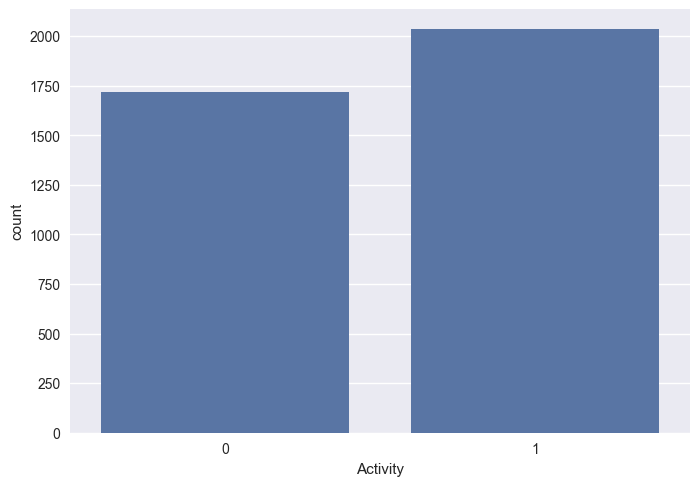

In [11]:
# проверим сбалансированность целевого показателя
sns.countplot(data=data, x='Activity');

Целевой показатель более-менее сбалансирован по классам.

In [12]:
# создадим матрицу наблюдений X и массив целевого признака y
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [13]:
# разобьем наши данные на тренировочную и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

In [14]:
# обучим модель логистической регрессии без дополнительных параметров
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_pred)))

f1_score train: 0.89
f1_score test: 0.78


In [16]:
# обучим модель случайного леса без дополнительных параметров
model_rf = ensemble.RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_train_rf_pred = model_rf.predict(X_train)
y_test_rf_pred = model_rf.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_rf_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_rf_pred)))

f1_score train: 1.00
f1_score test: 0.81


На базовой модели случайного леса на лицо переобучение, показатель f-меры равен 1.

1. GridSearchCV для получения лучшего набора гиперпараметров.

In [18]:
# применим GridSearchCV для логистичсекой регрессии
param_grid = [
              {'penalty': ['l2', 'none'] , 
              'solver': ['lbfgs', 'sag'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
y_train_gs_pred = grid_search.predict(X_train)
y_test_gs_pred = grid_search.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_gs_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_gs_pred)))

CPU times: total: 4.58 s
Wall time: 23min 18s
f1_score train: 0.85
f1_score test: 0.79


In [29]:
print('Наилучшие значения гиперпараметров: {}'.format(grid_search.best_params_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Наилучшее значение точности при кросс-валидаци: 0.76


In [31]:
# обучим модель логистической регрессии на подобранных параметрах
log_reg_opt_gs = linear_model.LogisticRegression(
    C=grid_search.best_params_['C'], 
    penalty=grid_search.best_params_['penalty'],
    solver=grid_search.best_params_[ 'solver'],
    max_iter=1000, 
    random_state=42)
log_reg_opt_gs.fit(X_train, y_train)
y_train_opt_gs_pred = log_reg_opt_gs.predict(X_train)
y_test_opt_gs_pred = log_reg_opt_gs.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_opt_gs_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_opt_gs_pred)))

f1_score train: 0.85
f1_score test: 0.79


Получилось чуть улучшить результат на тестовой выборке. Но время подбора составило 23 минуты.

In [28]:
# применим GridSearchCV для случайного леса
param_grid = {'n_estimators': list(range(100, 300, 20)),
              'min_samples_leaf': [5, 7, 10, 12],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_rf.fit(X_train, y_train) 
y_train_rf_gs_pred = grid_search_rf.predict(X_train)
y_test_rf_gs_pred = grid_search_rf.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_rf_gs_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_rf_gs_pred)))

CPU times: total: 17.4 s
Wall time: 20min 22s
f1_score train: 0.95
f1_score test: 0.83


In [32]:
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_rf.best_params_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search_rf.best_score_))

Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 5, 'n_estimators': 280}
Наилучшее значение точности при кросс-валидаци: 0.79


In [33]:
# обучим модель случайного леса на подобранных параметрах
model_rf_opt_gs = ensemble.RandomForestClassifier(
    max_depth=grid_search_rf.best_params_['max_depth'],
    min_samples_leaf=grid_search_rf.best_params_['min_samples_leaf'],
    n_estimators=grid_search_rf.best_params_['n_estimators'],
    random_state=42)
model_rf_opt_gs.fit(X_train, y_train)
y_train_rf_opt_gs_pred = model_rf_opt_gs.predict(X_train)
y_test_rf_opt_gs_pred = model_rf_opt_gs.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_rf_opt_gs_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_rf_opt_gs_pred)))

f1_score train: 0.95
f1_score test: 0.83


Получилось улучшить результат f-меры на тестовой выборке и уйти от переобучения модели. Но время подбора составило 20 минут.

2. RandomizeSearchCV для получения лучшего набора гиперпараметров.

In [34]:
# применим RandomizeSearchCV для логистической регрессии
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 20, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_train_rs_pred = random_search.predict(X_train)
y_test_rs_pred = random_search.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_rs_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_rs_pred)))

CPU times: total: 5.2 s
Wall time: 7min 3s
f1_score train: 0.85
f1_score test: 0.79


In [35]:
print('Наилучшие значения гиперпараметров: {}'.format(random_search.best_params_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(random_search.best_score_))

Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.12}
Наилучшее значение точности при кросс-валидаци: 0.76


In [36]:
# обучим модель логистической регрессии на подобранных параметрах
log_reg_opt_rs = linear_model.LogisticRegression(
    C=random_search.best_params_['C'], 
    penalty=random_search.best_params_['penalty'],
    solver=random_search.best_params_[ 'solver'],
    max_iter=1000, 
    random_state=42)
log_reg_opt_rs.fit(X_train, y_train)
y_train_opt_rs_pred = log_reg_opt_gs.predict(X_train)
y_test_opt_rs_pred = log_reg_opt_gs.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_opt_rs_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_opt_rs_pred)))

f1_score train: 0.85
f1_score test: 0.79


В результате подбора гиперпаратметров RandomizeSearchCV получили аналогичные результаты, что и с помощью GridSearchCV, но при этом затратили 7 минут (против 23 минут).

In [37]:
# применим RandomizeSearchCV для случайного леса
param_distributions = {'n_estimators': list(range(10, 300, 20)),
              'min_samples_leaf': [5, 7, 10, 12],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 20, 
    n_jobs = -1
)  
%time random_search_rf.fit(X_train, y_train) 
y_train_rf_rs_pred = random_search_rf.predict(X_train)
y_test_rf_rs_pred = random_search_rf.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_rf_rs_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_rf_rs_pred)))

CPU times: total: 2.28 s
Wall time: 47.4 s
f1_score train: 0.94
f1_score test: 0.83


In [38]:
print('Наилучшие значения гиперпараметров: {}'.format(random_search_rf.best_params_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(random_search_rf.best_score_))

Наилучшие значения гиперпараметров: {'n_estimators': 90, 'min_samples_leaf': 5, 'max_depth': 22}
Наилучшее значение точности при кросс-валидаци: 0.79


In [39]:
# обучим модель случайного леса на подобранных параметрах
model_rf_opt_rs = ensemble.RandomForestClassifier(
    max_depth=random_search_rf.best_params_['max_depth'],
    min_samples_leaf=random_search_rf.best_params_['min_samples_leaf'],
    n_estimators=random_search_rf.best_params_['n_estimators'],
    random_state=42)
model_rf_opt_rs.fit(X_train, y_train)
y_train_rf_opt_rs_pred = model_rf_opt_gs.predict(X_train)
y_test_rf_opt_rs_pred = model_rf_opt_gs.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_rf_opt_rs_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_rf_opt_rs_pred)))

f1_score train: 0.95
f1_score test: 0.83


В результате подбора гиперпаратметров RandomizeSearchCV получили аналогичные результаты, что и с помощью GridSearchCV, но при этом затратили 47 секунд (против 20 минут).

3. Heperopt для получения лучшего набора гиперпараметров.

In [134]:
# зададим пространство поиска гиперпараметров для логистической регрессии
param_log_reg = {'penalty': hp.choice(label='penalty_1', options=['l2', 'none']),
              'solver': hp.choice(label='solver_1', options=['lbfgs', 'sag']),
              'C': hp.uniform(label='C_1', low=0.01, high=1)}

In [150]:
random_state = 42
def hyperopt_lg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=500)
    # обучаем модель
    #model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
     # обучим модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

In [151]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() 
best = fmin(hyperopt_lg, 
          space=param_log_reg,
          algo=tpe.suggest,
          max_evals=20, 
          trials=trials, 
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [07:53<00:00, 23.67s/trial, best loss: -0.7833067410931183]
Наилучшие значения гиперпараметров {'C_1': 0.08292441519601887, 'penalty_1': 0, 'solver_1': 0}
CPU times: total: 1.36 s
Wall time: 7min 53s


In [152]:
print("Наилучшие значения гиперпараметров {}".format(hyperopt.space_eval(param_log_reg, best)))
dict_best = hyperopt.space_eval(param_log_reg, best)

Наилучшие значения гиперпараметров {'C': 0.08292441519601887, 'penalty': 'l2', 'solver': 'lbfgs'}


In [153]:
# обучим модель логистической регрессии на подобранных параметрах
log_reg_hyp = linear_model.LogisticRegression(
    C=dict_best['C'], 
    penalty=dict_best['penalty'],
    solver=dict_best[ 'solver'],
    max_iter=1000, 
    random_state=42)
log_reg_hyp.fit(X_train, y_train)
y_train_hyp_pred = log_reg_opt_gs.predict(X_train)
y_test_hyp_pred = log_reg_opt_gs.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_hyp_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_hyp_pred)))

f1_score train: 0.85
f1_score test: 0.79


В результате подбора гиперпаратметров Hyperopt получили аналогичные результаты, что и с помощью предудыщих оптимизаторов, но при этом с учетом кросс-валидации затратили 8 минут (против 7 минут и 23 минут).

In [145]:
# зададим пространство поиска гиперпараметров для случайного леса
space_rf = {'n_estimators': hp.quniform('n_estimators', 10, 300, 20),
       'max_depth_rf' : hp.choice(label='max_depth', options=[5, 7, 10, 12]),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 20, 40, 10)
      }

In [144]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth_rf']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    # обучаем модель
    #model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    # обучим модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

In [147]:
%%time
trials_2 = Trials()
best_rf = fmin(hyperopt_rf,
          space=space_rf, 
          algo=tpe.suggest,
          max_evals=20, 
          trials=trials_2, 
          rstate=np.random.default_rng(random_state)
         )

100%|██████████| 20/20 [00:55<00:00,  2.79s/trial, best loss: -0.7825295179699399]
CPU times: total: 1.45 s
Wall time: 55.8 s


In [148]:
print("Наилучшие значения гиперпараметров {}".format(best_rf))

Наилучшие значения гиперпараметров {'max_depth': 2, 'min_samples_leaf': 20.0, 'n_estimators': 220.0}


In [149]:
# обучим модель случайного леса на подобранных параметрах
model_rf_hyp = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf'])
)
model_rf_hyp.fit(X_train, y_train)
y_train_rf_opt_hyp_pred = model_rf_opt_gs.predict(X_train)
y_test_rf_opt_hyp_pred = model_rf_opt_gs.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_rf_opt_hyp_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_rf_opt_hyp_pred)))

f1_score train: 0.95
f1_score test: 0.83


В результате подбора гиперпаратметров Hyperopt получили аналогичные результаты, что и с помощью предудыщих оптимизаторов, но при этом с учетом кросс-валидации затратили 56 секунд (против 47 секунд и 20 минут).

4. Optuna для получения лучшего набора гиперпараметров.

In [174]:
def optuna_lg(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C_opt = trial.suggest_float(name='C', low=0.1, high=1, step=0.1, log=False)

  # создаем модель
  model = linear_model.LogisticRegression(
    penalty=penalty,
    solver=solver,
    C=C_opt,
    random_state=random_state,
    max_iter=500
    )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [175]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_lg = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_lg.optimize(optuna_lg, n_trials=20)

[I 2024-04-08 10:09:33,564] A new study created in memory with name: LogisticRegression
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2024-04-08 10:09:51,285] Trial 0 finished with value: 0.9172519083969467 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.1}. Best is trial 0 with value: 0.9172519083969467.
C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic

CPU times: total: 4min 22s
Wall time: 2min 18s


In [176]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_lg.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_lg.best_value))

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.30000000000000004}
f1_score на обучающем наборе: 0.97


In [181]:
# рассчитаем точность для тестовой выборки
model_lg_optiuna = linear_model.LogisticRegression(
    penalty=study_lg.best_params['penalty'],
    solver=study_lg.best_params['solver'],
    C=study_lg.best_params['C'],
    random_state=random_state, 
    max_iter=500)
model_lg_optiuna.fit(X_train, y_train)
y_train_rf_optuna_pred = model_lg_optiuna.predict(X_train)
y_test_rf_optuna_pred = model_lg_optiuna.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_rf_optuna_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_rf_optuna_pred)))

C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



f1_score train: 0.97
f1_score test: 0.72


C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [163]:
# отобразим график истории оптимизации
optuna.visualization.plot_optimization_history(study_lg, target_name='f1_score')

In [164]:
# отобразим на контурном графике взаимосвязь метрики и гиперпараметров
optuna.visualization.plot_contour(study_lg, params=['penalty', 'solver', 'C'],
                                  target_name='f1_score')

По результатам подбора гиперпараметров с помощью Optuna получается на вид переобучение модели.

In [165]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 20)
  max_depth = trial.suggest_int('max_depth', 5, 12, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 20, 40, 5)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [166]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)

[I 2024-04-08 09:57:41,913] A new study created in memory with name: RandomForestClassifier
C:\Users\vadim.kopytko\AppData\Local\Temp\ipykernel_5300\2177525682.py:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

C:\Users\vadim.kopytko\AppData\Local\Temp\ipykernel_5300\2177525682.py:4: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

C:\Users\vadim.kopytko\AppData\Local\Temp\ipykernel_5300\2177525682.py:5: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-04-08 09:57:42,946] Trial 0 finished with value: 0.8300274641440342 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 25}. Best is trial 0 with value: 0.8300274641440342.
C:\Users\vadim.kopytko\AppData\Local\Temp\ipykernel_5300\2177525682.py:3: FutureWarning:

suggest_int() got 

CPU times: total: 42.9 s
Wall time: 43.2 s


In [167]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 260, 'max_depth': 11, 'min_samples_leaf': 20}
f1_score на обучающем наборе: 0.85


In [168]:
# рассчитаем точность для тестовой выборки
model_rf_optuna = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=random_state, )
model_rf_optuna.fit(X_train, y_train)
y_train_rf_optuna_pred = model_rf_optuna.predict(X_train)
y_test_rf_optuna_pred = model_rf_optuna.predict(X_test)
print('f1_score train: {:.2f}'.format(metrics.f1_score(y_train,  y_train_rf_optuna_pred)))
print('f1_score test: {:.2f}'.format(metrics.f1_score(y_test,  y_test_rf_optuna_pred)))

f1_score train: 0.85
f1_score test: 0.80


In [169]:
# отобразим график истории оптимизации
optuna.visualization.plot_optimization_history(study_rf, target_name='f1_score')

In [170]:
# отобразим на контурном графике взаимосвязь метрики и гиперпараметров
optuna.visualization.plot_contour(study_rf, params=['max_depth', 'n_estimators'],
                                  target_name='f1_score')

С помощью Optuna получили наилучший результат метрики f-меры, затратив при этом всего 43 секунды.

**Общий вывод:** Проведенный ананлиз методов подбора гиперпараметров показал, что все методы подбора получают на выходе сходие результаты, однако, продвинутые методы являются более удобными и более производительными, то есть затрачивают меньше ресурсов и времени на получение результа. Плюс метод Optuna имееет дополнительные преимущества в готовых решениях по визуализации результатов.